In [58]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

col_names = ["duration","protocol_type","service","flag","src_bytes",
"dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
"logged_in","num_compromised","root_shell","su_attempted","num_root",
"num_file_creations","num_shells","num_access_files","num_outbound_cmds",
"is_host_login","is_guest_login","count","srv_count","serror_rate",
"srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
"diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
"dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","class","difficulty"]

nominal_cols = ['protocol_type','service','flag']
binary_cols = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login',
'is_guest_login']
continuous_cols = ['duration' ,'src_bytes', 'dst_bytes', 'wrong_fragment' ,'urgent', 'hot',
'num_failed_logins', 'num_compromised', 'num_root' ,'num_file_creations',
'num_shells', 'num_access_files', 'num_outbound_cmds', 'count' ,'srv_count',
'serror_rate', 'srv_serror_rate' ,'rerror_rate' ,'srv_rerror_rate',
'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate' ,'dst_host_count',
'dst_host_srv_count' ,'dst_host_same_srv_rate' ,'dst_host_diff_srv_rate',
'dst_host_same_src_port_rate' ,'dst_host_srv_diff_host_rate',
'dst_host_serror_rate' ,'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate']

class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        dos = ['apache2', 'back', 'land', 'neptune', 
               'mailbomb', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
        probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
        u2r = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']
        r2l = ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 'named', 
               'phf', 'sendmail', 'snmpgetattack', 'spy', 'snmpguess', 'warezclient', 
               'warezmaster', 'xlock', 'xsnoop']
        label_to_binary = udf(lambda name: 0.0 if name == 'normal' else 
                              (1.0 if name in dos else 
                               (2.0 if name in probe else 
                                (3.0 if name in u2r else 4.0))))
        output_df = dataset.withColumn('outcome', label_to_binary(col('class'))).drop("class")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        output_df = output_df.drop('difficulty')
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
                     "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    for col_name in corelated_cols_to_remove:
        feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features'])
    

    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    
    return pipeline 

In [59]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

nslkdd_raw = spark.read.csv('../NSL-KDD/KDDTrain+.txt',header=False).toDF(*col_names)
nslkdd_test_raw = spark.read.csv('../NSL-KDD/KDDTest+.txt',header=False).toDF(*col_names)

preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(nslkdd_raw)

nslkdd_df = preprocess_pipeline_model.transform(nslkdd_raw)
nslkdd_df_test = preprocess_pipeline_model.transform(nslkdd_test_raw)


In [60]:
nslkdd_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)



In [61]:
nslkdd_df.groupBy('outcome').count().show()

+-------+-----+
|outcome|count|
+-------+-----+
|    0.0|67343|
|    1.0|45927|
|    4.0|  995|
|    3.0|   52|
|    2.0|11656|
+-------+-----+



# Using Random Forest model

In [62]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'outcome')
rf_model = rf.fit(nslkdd_df)



In [63]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="outcome", predictionCol="prediction", metricName="accuracy")


rf_prediction_train = rf_model.transform(nslkdd_df)
rf_prediction_test = rf_model.transform(nslkdd_df_test)

rf_accuracy_train = evaluator.evaluate(rf_prediction_train)
rf_accuracy_test = evaluator.evaluate(rf_prediction_test)


print(f"Train accuracy = {np.round(rf_accuracy_train*100,2)}%, test accuracy = {np.round(rf_accuracy_test*100,2)}%")

Train accuracy = 96.46%, test accuracy = 71.72%


In [64]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[9516    3  192    0    0]
 [2199 5256    5    0    0]
 [ 673  351 1397    0    0]
 [  67    0    0    0    0]
 [2839    0   46    0    0]]


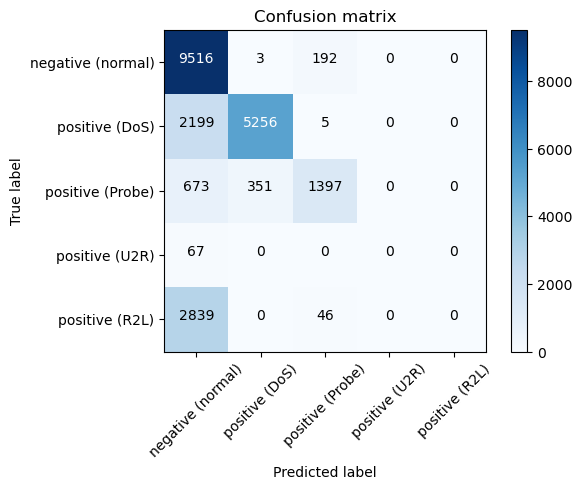

In [65]:
class_names=[0.0,1.0, 2.0, 3.0, 4.0]
class_names_str=["negative (normal)","positive (DoS)", "positive (Probe)", "positive (U2R)", "positive (R2L)"]

outcome_true = rf_prediction_test.select("outcome")
outcome_true = outcome_true.toPandas()

pred = rf_prediction_test.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

# Using Random Naive Bayes

In [66]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol = 'features', labelCol = 'outcome', modelType = "gaussian" )
nb_model = nb.fit(nslkdd_df)



In [67]:
nb_prediction_train = nb_model.transform(nslkdd_df)
nb_prediction_test = nb_model.transform(nslkdd_df_test)

nb_accuracy_train = evaluator.evaluate(nb_prediction_train)
nb_accuracy_test = evaluator.evaluate(nb_prediction_test)


print(f"Train accuracy = {np.round(nb_accuracy_train*100,2)}%, test accuracy = {np.round(nb_accuracy_test*100,2)}%")


Train accuracy = 61.48%, test accuracy = 39.2%


Confusion matrix, without normalization
[[5345   57   10  328 3971]
 [3751 2470    0   59 1180]
 [1570  277  103  138  333]
 [   5    0    0   58    4]
 [1393    3    6  622  861]]


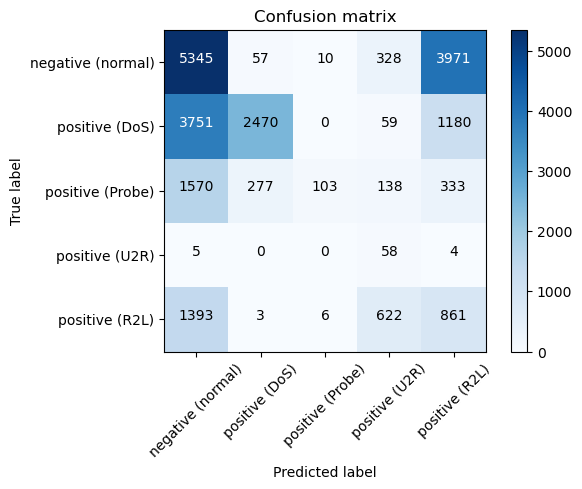

In [68]:
outcome_true = nb_prediction_test.select("outcome")
outcome_true = outcome_true.toPandas()

pred = nb_prediction_test.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

# Cross validation

In [57]:
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [10, 15, 25])# maximum depth for each tree
             .addGrid(rf.numTrees,[10, 20, 40])# number of trees
             .build())

rf_cv = CrossValidator(estimator=rf, estimatorParamMaps=rf_paramGrid, 
                    evaluator=evaluator, numFolds=5)

rf_cv_model = rf_cv.fit(nslkdd_df)

rf_cv_prediction_test = rf_cv_model.transform(nslkdd_df_test)
rf_cv_acc = evaluator.evaluate(rf_cv_prediction_test)


22/10/23 23:02:04 WARN DAGScheduler: Broadcasting large task binary with size 1035.1 KiB


22/10/23 23:02:05 WARN DAGScheduler: Broadcasting large task binary with size 1382.9 KiB


22/10/23 23:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1773.9 KiB


22/10/23 23:02:07 WARN DAGScheduler: Broadcasting large task binary with size 1225.7 KiB
22/10/23 23:02:10 WARN DAGScheduler: Broadcasting large task binary with size 1073.1 KiB
22/10/23 23:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1164.2 KiB
22/10/23 23:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1361.6 KiB
22/10/23 23:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1551.3 KiB
22/10/23 23:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1725.3 KiB
22/10/23 23:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1883.5 KiB
22/10/23 23:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1152.1 KiB


22/10/23 23:02:21 WARN DAGScheduler: Broadcasting large task binary with size 1035.1 KiB


22/10/23 23:02:22 WARN DAGScheduler: Broadcasting large task binary with size 1382.9 KiB


22/10/23 23:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1773.9 KiB


22/10/23 23:02:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/23 23:02:25 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:02:26 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/23 23:02:27 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/10/23 23:02:28 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/10/23 23:02:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/10/23 23:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1073.1 KiB
22/10/23 23:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1146.4 KiB
22/10/23 23:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1205.8 KiB
22/10/23 23:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1247.8 KiB
22/10/23 23:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1280.1 KiB
22/10/23 23:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1302.2 KiB
22/10/23 23:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1206.8 KiB
22/10/23 23:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1218.3 KiB
22/10/23 23:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1226.1 KiB
22/10/23 23:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1141.2 KiB
22/10/23 23:02:38 WARN D

22/10/23 23:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1035.0 KiB


22/10/23 23:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1382.9 KiB


22/10/23 23:02:50 WARN DAGScheduler: Broadcasting large task binary with size 1773.9 KiB


22/10/23 23:02:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/23 23:02:52 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:02:53 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/23 23:02:54 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/10/23 23:02:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/10/23 23:02:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/10/23 23:02:57 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/10/23 23:02:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/10/23 23:02:59 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/10/23 23:03:00 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/10/23 23:03:01 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/10/23 23:03:02 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/10/23 23:03:03 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/10/23 23:03:04 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/10/23 23:03:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/10/23 23:03:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:03:17 WARN DAGScheduler: Broadcasting large task binary with size 1043.4 KiB


22/10/23 23:03:17 WARN DAGScheduler: Broadcasting large task binary with size 1398.2 KiB


22/10/23 23:03:18 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB


22/10/23 23:03:19 WARN DAGScheduler: Broadcasting large task binary with size 1214.3 KiB
22/10/23 23:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1025.7 KiB
22/10/23 23:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB
22/10/23 23:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1395.8 KiB
22/10/23 23:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1588.2 KiB
22/10/23 23:03:28 WARN DAGScheduler: Broadcasting large task binary with size 1756.7 KiB
22/10/23 23:03:28 WARN DAGScheduler: Broadcasting large task binary with size 1901.3 KiB
22/10/23 23:03:29 WARN DAGScheduler: Broadcasting large task binary with size 1148.0 KiB


22/10/23 23:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1043.4 KiB


22/10/23 23:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1398.2 KiB


22/10/23 23:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1788.1 KiB


22/10/23 23:03:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/23 23:03:37 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:03:38 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/23 23:03:39 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/10/23 23:03:40 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/10/23 23:03:41 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/10/23 23:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1025.7 KiB
22/10/23 23:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/10/23 23:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1137.4 KiB
22/10/23 23:03:45 WARN DAGScheduler: Broadcasting large task binary with size 1173.7 KiB
22/10/23 23:03:45 WARN DAGScheduler: Broadcasting large task binary with size 1109.6 KiB
22/10/23 23:03:45 WARN DAGScheduler: Broadcasting large task binary with size 1127.6 KiB
22/10/23 23:03:45 WARN DAGScheduler: Broadcasting large task binary with size 1029.7 KiB
22/10/23 23:03:45 WARN DAGScheduler: Broadcasting large task binary with size 1040.5 KiB
22/10/23 23:03:49 WARN DAGScheduler: Broadcasting large task binary with size 1187.3 KiB
22/10/23 23:03:50 WARN DAGScheduler: Broadcasting large task binary with size 1395.8 KiB
22/10/23 23:03:50 WARN D

22/10/23 23:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1043.4 KiB


22/10/23 23:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1398.2 KiB
22/10/23 23:04:01 WARN DAGScheduler: Broadcasting large task binary with size 1788.1 KiB


22/10/23 23:04:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/23 23:04:03 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:04:04 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/23 23:04:05 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/10/23 23:04:06 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/10/23 23:04:07 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/10/23 23:04:08 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/10/23 23:04:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/10/23 23:04:10 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/10/23 23:04:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/10/23 23:04:12 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/10/23 23:04:13 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/10/23 23:04:13 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/10/23 23:04:14 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/10/23 23:04:14 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/10/23 23:04:15 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1036.8 KiB


22/10/23 23:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1392.8 KiB


22/10/23 23:04:29 WARN DAGScheduler: Broadcasting large task binary with size 1788.4 KiB


22/10/23 23:04:30 WARN DAGScheduler: Broadcasting large task binary with size 1228.8 KiB
22/10/23 23:04:33 WARN DAGScheduler: Broadcasting large task binary with size 1044.9 KiB
22/10/23 23:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1152.9 KiB
22/10/23 23:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1361.8 KiB
22/10/23 23:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1561.1 KiB
22/10/23 23:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1737.4 KiB
22/10/23 23:04:39 WARN DAGScheduler: Broadcasting large task binary with size 1889.4 KiB
22/10/23 23:04:39 WARN DAGScheduler: Broadcasting large task binary with size 1168.0 KiB


22/10/23 23:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1036.8 KiB
22/10/23 23:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1392.8 KiB


22/10/23 23:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1788.4 KiB


22/10/23 23:04:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/23 23:04:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/23 23:04:49 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/23 23:04:50 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/10/23 23:04:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/10/23 23:04:52 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/10/23 23:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1044.9 KiB
22/10/23 23:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1103.9 KiB
22/10/23 23:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1149.6 KiB
22/10/23 23:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1185.7 KiB
22/10/23 23:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1211.5 KiB
22/10/23 23:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1230.7 KiB
22/10/23 23:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1246.7 KiB
22/10/23 23:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1260.0 KiB
22/10/23 23:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1175.3 KiB
22/10/23 23:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1082.5 KiB
22/10/23 23:05:01 WARN D

22/10/23 23:05:11 WARN DAGScheduler: Broadcasting large task binary with size 1036.8 KiB


22/10/23 23:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1392.8 KiB


22/10/23 23:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1788.4 KiB


22/10/23 23:05:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/23 23:05:15 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/23 23:05:16 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/23 23:05:17 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/10/23 23:05:18 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/10/23 23:05:19 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/10/23 23:05:20 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/10/23 23:05:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/10/23 23:05:22 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/10/23 23:05:23 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/10/23 23:05:24 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/10/23 23:05:25 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/10/23 23:05:26 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/10/23 23:05:26 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/10/23 23:05:27 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/10/23 23:05:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/23 23:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB


22/10/23 23:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1360.6 KiB


22/10/23 23:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1738.7 KiB


22/10/23 23:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1189.3 KiB
22/10/23 23:05:46 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
22/10/23 23:05:49 WARN DAGScheduler: Broadcasting large task binary with size 1148.4 KiB
22/10/23 23:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1348.1 KiB
22/10/23 23:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1538.5 KiB
22/10/23 23:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1714.8 KiB
22/10/23 23:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1863.6 KiB
22/10/23 23:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1129.2 KiB


22/10/23 23:05:56 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB


22/10/23 23:05:57 WARN DAGScheduler: Broadcasting large task binary with size 1360.6 KiB


22/10/23 23:05:58 WARN DAGScheduler: Broadcasting large task binary with size 1738.7 KiB


22/10/23 23:05:59 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/23 23:06:00 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:06:00 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/10/23 23:06:01 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/10/23 23:06:02 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/10/23 23:06:03 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/10/23 23:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
22/10/23 23:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1122.9 KiB
22/10/23 23:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1177.9 KiB
22/10/23 23:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1220.3 KiB
22/10/23 23:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1254.5 KiB
22/10/23 23:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1281.0 KiB
22/10/23 23:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1300.5 KiB
22/10/23 23:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1205.3 KiB
22/10/23 23:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1096.5 KiB
22/10/23 23:06:12 WARN DAGScheduler: Broadcasting large task binary with size 1148.4 KiB
22/10/23 23:06:12 WARN D

22/10/23 23:06:22 WARN DAGScheduler: Broadcasting large task binary with size 1018.0 KiB


22/10/23 23:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1360.6 KiB


22/10/23 23:06:24 WARN DAGScheduler: Broadcasting large task binary with size 1738.7 KiB


22/10/23 23:06:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/10/23 23:06:25 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:06:26 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/10/23 23:06:28 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/10/23 23:06:29 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/10/23 23:06:30 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/10/23 23:06:31 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/10/23 23:06:32 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/10/23 23:06:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/10/23 23:06:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/10/23 23:06:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/10/23 23:06:36 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/10/23 23:06:36 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/10/23 23:06:37 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/10/23 23:06:38 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/10/23 23:06:38 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/10/23 23:06:51 WARN DAGScheduler: Broadcasting large task binary with size 1053.5 KiB


22/10/23 23:06:52 WARN DAGScheduler: Broadcasting large task binary with size 1417.8 KiB


22/10/23 23:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1810.8 KiB


22/10/23 23:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1239.8 KiB
22/10/23 23:06:56 WARN DAGScheduler: Broadcasting large task binary with size 1042.2 KiB
22/10/23 23:07:00 WARN DAGScheduler: Broadcasting large task binary with size 1137.2 KiB
22/10/23 23:07:01 WARN DAGScheduler: Broadcasting large task binary with size 1342.5 KiB
22/10/23 23:07:01 WARN DAGScheduler: Broadcasting large task binary with size 1541.2 KiB
22/10/23 23:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1712.9 KiB
22/10/23 23:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1863.3 KiB
22/10/23 23:07:03 WARN DAGScheduler: Broadcasting large task binary with size 1136.2 KiB


22/10/23 23:07:07 WARN DAGScheduler: Broadcasting large task binary with size 1053.5 KiB


22/10/23 23:07:08 WARN DAGScheduler: Broadcasting large task binary with size 1417.8 KiB


22/10/23 23:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1810.8 KiB


22/10/23 23:07:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/23 23:07:12 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/23 23:07:13 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/23 23:07:14 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/10/23 23:07:15 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/10/23 23:07:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/10/23 23:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1042.2 KiB
22/10/23 23:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1106.8 KiB
22/10/23 23:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1157.7 KiB
22/10/23 23:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1197.9 KiB
22/10/23 23:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1226.5 KiB
22/10/23 23:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1248.2 KiB
22/10/23 23:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1266.8 KiB
22/10/23 23:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1281.8 KiB
22/10/23 23:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1199.3 KiB
22/10/23 23:07:21 WARN DAGScheduler: Broadcasting large task binary with size 1208.0 KiB
22/10/23 23:07:21 WARN D

22/10/23 23:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1053.5 KiB


22/10/23 23:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1417.8 KiB


22/10/23 23:07:37 WARN DAGScheduler: Broadcasting large task binary with size 1810.8 KiB


22/10/23 23:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/23 23:07:39 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/23 23:07:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/10/23 23:07:41 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/10/23 23:07:42 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/10/23 23:07:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/10/23 23:07:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/10/23 23:07:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/10/23 23:07:46 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/10/23 23:07:48 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/10/23 23:07:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/10/23 23:07:50 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/10/23 23:07:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/10/23 23:07:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/10/23 23:07:52 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/10/23 23:07:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/23 23:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1019.7 KiB


22/10/23 23:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1381.3 KiB


22/10/23 23:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1801.3 KiB


22/10/23 23:08:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/10/23 23:08:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/10/23 23:08:06 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/10/23 23:08:07 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/10/23 23:08:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/10/23 23:08:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/10/23 23:08:10 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/10/23 23:08:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/10/23 23:08:13 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/10/23 23:08:14 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/10/23 23:08:15 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/10/23 23:08:17 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/10/23 23:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/10/23 23:08:19 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/10/23 23:08:20 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/10/23 23:08:21 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


In [58]:
print(f"Before cross-validation and parameter tuning, AUC={np.round(rf_accuracy_test*100,2)}%")
print(f"After cross-validation and parameter tuning, AUC={np.round(rf_cv_acc*100,2)}%")

Before cross-validation and parameter tuning, AUC=71.72%
After cross-validation and parameter tuning, AUC=74.51%


In [69]:
nb_paramGrid = (ParamGridBuilder()
             .addGrid(nb.thresholds,[[5, 0, 1, 50, 10000],[0.5, 0, 1, 80, 20000],[1, 0.0001, 1, 100, 40000]])# threshold modifier for each label
             .addGrid(nb.smoothing,[1, 5, 8])# smoothing parameter
             .build())

nb_cv = CrossValidator(estimator=nb, estimatorParamMaps=nb_paramGrid, 
                    evaluator=evaluator, numFolds=5)

nb_cv_model = nb_cv.fit(nslkdd_df)

nb_cv_prediction_test = nb_cv_model.transform(nslkdd_df_test)
nb_cv_acc = evaluator.evaluate(nb_cv_prediction_test)


In [111]:
print(f"Before cross-validation and parameter tuning, AUC={np.round(nb_accuracy_test*100,2)}%")
print(f"After cross-validation and parameter tuning, AUC={np.round(nb_cv_acc*100,2)}%")

Before cross-validation and parameter tuning, AUC=39.2%
After cross-validation and parameter tuning, AUC=40.77%


Confusion matrix, without normalization
[[5603   57   10  327 3714]
 [3655 2566    0   59 1180]
 [1570  277  103  138  333]
 [   5    0    0   58    4]
 [1393    3    6  622  861]]


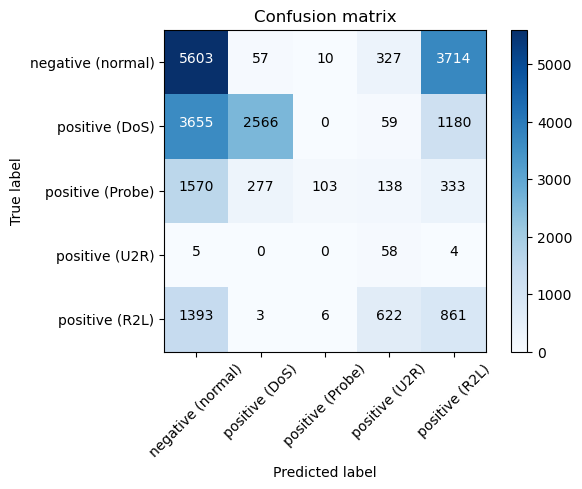

In [70]:
outcome_true = nb_cv_prediction_test.select("outcome")
outcome_true = outcome_true.toPandas()

pred = nb_cv_prediction_test.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

## Testing with Multi Layer Perceptron model

In [19]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

mlp = MultilayerPerceptronClassifier(featuresCol = 'features', labelCol = 'outcome', layers = [113, 5, 5])
mlp_model = mlp.fit(nslkdd_df)


22/10/27 10:41:51 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/27 10:41:51 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/10/27 10:41:51 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/10/27 10:41:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/27 10:41:51 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [27]:
mlp_prediction_train = mlp_model.transform(nslkdd_df)
mlp_prediction_test = mlp_model.transform(nslkdd_df_test)

mlp_accuracy_train = evaluator.evaluate(mlp_prediction_train)
mlp_accuracy_test = evaluator.evaluate(mlp_prediction_test)


print(f"Train accuracy = {np.round(mlp_accuracy_train*100,2)}%, test accuracy = {np.round(mlp_accuracy_test*100,2)}%")


Train accuracy = 98.12%, test accuracy = 72.62%


Confusion matrix, without normalization
[[9038  419  250    0    4]
 [1761 5622   77    0    0]
 [ 562  170 1681    0    8]
 [  56    3    7    0    1]
 [2838    2   15    0   30]]


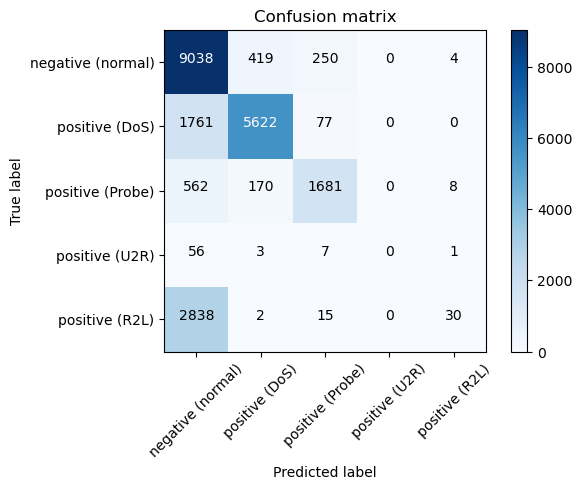

In [29]:
outcome_true = mlp_prediction_test.select("outcome")
outcome_true = outcome_true.toPandas()

pred = mlp_prediction_test.select("prediction")
pred = pred.toPandas()

cnf_matrix = confusion_matrix(outcome_true, pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names_str,
                      title='Confusion matrix')
plt.show()

In [53]:
mlp_paramGrid = (ParamGridBuilder()
             .addGrid(mlp.layers,[[113, 5, 5],[113, 10, 5],[113, 5, 10, 5], [113, 20, 20, 10, 5]])# layer configuration (only hidden layers are modified).
             .addGrid(mlp.maxIter,[10, 30, 50, 100, 200])# number of iterations
             .build())

mlp_cv = CrossValidator(estimator=mlp, estimatorParamMaps=mlp_paramGrid, 
                    evaluator=evaluator, numFolds=5)

mlp_cv_model = mlp_cv.fit(nslkdd_df)

mlp_cv_prediction_test = mlp_cv_model.transform(nslkdd_df_test)
mlp_cv_acc = evaluator.evaluate(mlp_cv_prediction_test)


In [55]:
print(f"Before cross-validation and parameter tuning, AUC={np.round(mlp_accuracy_test*100,2)}%")
print(f"After cross-validation and parameter tuning, AUC={np.round(mlp_cv_acc*100,2)}%")

Before cross-validation and parameter tuning, AUC=72.62%
After cross-validation and parameter tuning, AUC=77.93%


### Q2-4

I first chose the random forest (rf) and naive Bayes (nb) classifier ml models because, according to [Pyspark Documentation](https://spark.apache.org/docs/3.1.3/api/python/reference/pyspark.ml.html?highlight=classification), these are the only models that support multiclass, besides the decision tree model and multilayer perceptron (mlp). I didn't choose the decision tree since random forest is a more robust model for this. I wasn't sure if mlp was an allowed model, since it's getting into deep learning, but later on I decided to also test it since nb proved to be an inadequate model because of correlation between features.

#### Random Forest

This model was seen in the spark ML lectures, it had a decent initial test accuracy of 71%, relative to the other models tested. For hyper-parameter tuning, I selected the maximum depth of the trees and the number of trees, these directly affect the accuracy of the model, but can also cause overfitting easily, so the parameter grid had a low value, a higher value and another in between. The result was a 3% increase in accuracy, however the warnings displayed during cross-validation indicate that it uses a lot of memory.

#### Naive Bayes

This model was also seen in the spark ML lectures, it is a good classifier with support for multiclass, but it assumes that features have minimal correlation. This isn't the case with the NSL-KDD database, we have seen in class that there are features that have a level of correlation with each other. This affected the model and caused it to have very low accuracy, even with the training data it didn't reach 70%. For hyper-parameter tuning, I chose smoothing and the output thresholds to affect which label is selected. I tried various combinations of parameter grid, basing it off the confusion matrix to select thresholds, but the increase in accuracy was very slim, only getting a 1.5% increase in the end.

#### Multlayer Perceptron

This is a neural network model, it was mentioned in the lectures while introducing tensorflow and pytorch, but we didn't use it in spark during class. I decided to try it since naive Bayes wasn't very adequate to the data. Initial accuracy was good, similar to random forest at 72.6%. For the hyper-parameter tuning I chose the layers and number of iterations, these two parameters greatly affect the output, but they also carry a risk of overfitting, particularly the iterations being too high. For the layers tuning, only hidden layers were changed, and I tested different size of layer and also adding a second hidden layer. As for the iterations, I tried various numbers, going from very low at 10 and a high number at 200 (the evaluation took very long to run (~20 min), so I didn't go any higher in iterations), with a few intermediate numbers. This tuning had the best result, with a ~5%  increase in accuracy. This took the longest to run, but it didn't give me warnings like random forest.

Comparing the models, naive Bayes is definitely not well suited for the NSL-KDD dataset, since the features have some correlation between them, and it wasn't able to handle this well. The random forest and mlp models performed much better, but each has its own limitations in memory usage and training time, respectively.
In the end, I believe tensorflow and pytorch will perform better for neural networks and deep learning, so for spark ML, random forest might be the preferred model of the ones I tested in this homework.